In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

def whittle_index_reliable(age, cost_function):
    """Reliable: W(h) = h*f(h+1) - Σf(j)"""
    h = age
    term1 = h * cost_function(h + 1)
    term2 = np.sum(cost_function(np.arange(1, h + 1)))
    return term1 - term2

def whittle_index_unreliable(age, cost_func, reliability, max_k=200):
    """Unreliable: W(h) = p²h·Σf(k+h)·(1-p)^(k-1) - p·Σf(j)"""
    h = age
    p = reliability
    
    # Vectorized computation of both sums, k goes to infinity, so cap it
    k_vals = np.arange(1, max_k + 1)
    j_vals = np.arange(1, h + 1)
    
    term1 = (p**2) * h * np.sum(cost_func(k_vals + h) * (1 - p)**(k_vals - 1))
    term2 = p * np.sum(cost_func(j_vals))
    
    return term1 - term2

In [2]:
def simulate_whittle_optimized(cost_funcs, reliabilities, time_slots=500, verbose=False):
    """
    Simulation for average cost of the whittle index
    
    Args:
        cost_funcs: List of cost functions
        reliabilities: List of transmission success probabilities
        time_slots: Number of time slots to simulate
        verbose: Print progress
    
    Returns:
        Average cost per time slot, we want to compute it
    """
    N = len(cost_funcs)
    ages = np.ones(N, dtype=int)  # array to represents N sensors, all start with 1
    total_cost = 0 #for the final average cost
    
    # Determine if channels are reliable
    all_reliable = all(p == 1.0 for p in reliabilities)
    
    for t in range(time_slots): #run the simulations
        # Calculate current cost 
        current_cost = sum(cost_funcs[i](ages[i]) for i in range(N))
        total_cost += current_cost
        
        # Calculate Whittle Index for each source
        indices = np.zeros(N)
        for i in range(N):
            if reliabilities[i] == 1.0:
                #notice that they have different formulas, reliable or unreliable
                indices[i] = whittle_index_reliable(ages[i], cost_funcs[i])
            else:
                indices[i] = whittle_index_unreliable(ages[i], cost_funcs[i], reliabilities[i])
        
        # Select source with maximum index (priority score)
        selected = np.argmax(indices)
        
        # Update ages
        for i in range(N):
            if i == selected:
                # Bernoulli trial for transmission
                success = np.random.binomial(1, reliabilities[i])
                ages[i] = 1 if success else ages[i] + 1
            else:
                ages[i] += 1
        
        if verbose and t % 100 == 0:
            print(f"  Time slot {t}/{time_slots}: cost={current_cost:.2f}")
    
    return total_cost / time_slots

In [3]:
def replicate_table_1_optimized():
    """Replicate Table I using optimized functions"""
    
    print("\n" + "="*70)
    print("REPLICATING TABLE I (Optimized Version)")
    print("="*70)
    
    test_cases = [
        # (name, cost1, cost2, prob of success 1, p2)
        # from the paper, see section 6 
        ("A1", lambda x: 13*x, lambda x: x**2, 1.0, 1.0),
        ("A2", lambda x: 13*x, lambda x: x**2, 0.9, 0.5),
        ("B1", lambda x: x**2, lambda x: 3**x, 1.0, 1.0),
        ("B2", lambda x: x**2, lambda x: 3**x, 0.65, 0.8),
        ("C1", lambda x: (x**3)/2, lambda x: 10*np.log(np.maximum(x, 1)), 1.0, 1.0),
        ("C2", lambda x: (x**3)/2, lambda x: 10*np.log(np.maximum(x, 1)), 0.55, 0.75),
    ]
    
    for name, f1, f2, p1, p2 in test_cases:
        cost_funcs = [f1, f2]
        reliabilities = [p1, p2]
        
        # For unreliable, run multiple times
        if p1 < 1.0 or p2 < 1.0:
            costs = []
            for _ in range(100):
                cost = simulate_whittle_optimized(cost_funcs, reliabilities, 500)
                costs.append(cost)
            avg_cost = np.mean(costs)
            std_cost = np.std(costs)
            print(f"{name}: {avg_cost:6.2f} ± {std_cost:5.2f} (unreliable)")
        else:
            cost = simulate_whittle_optimized(cost_funcs, reliabilities, 500)
            print(f"{name}: {cost:6.2f} (reliable)")


# Run it!
replicate_table_1_optimized()


REPLICATING TABLE I (Optimized Version)
A1:  21.97 (reliable)
A2:  36.10 ±  2.70 (unreliable)
B1:   8.49 (reliable)
B2:  23.18 ±  7.20 (unreliable)
C1:   5.70 (reliable)
C2:  22.03 ±  3.42 (unreliable)


In [4]:
def replicate_table_2():
    """Replicate Table II from the paper"""
    
    print("\n" + "="*70)
    print("REPLICATING TABLE II")
    print("="*70)
    
    # All test cases: (name, cost_functions_list, reliabilities_list)
    test_cases = [
        ("D1", [lambda x: x**2, lambda x: 3**x, lambda x: x**4], 
         [1.0, 1.0, 1.0]),
        
        ("D2", [lambda x: x**2, lambda x: 3**x, lambda x: x**4], 
         [0.66, 0.8, 0.75]),
        
        ("E1", [lambda x: x**3, lambda x: 2**x, lambda x: 15*x, lambda x: x**2], 
         [1.0, 1.0, 1.0, 1.0]),
        
        ("E2", [lambda x: x**3, lambda x: 2**x, lambda x: 15*x, lambda x: x**2], 
         [0.7, 0.9, 0.67, 0.8]),
        
        ("F1", [lambda x: x**3, lambda x: np.exp(x), lambda x: 15*x, lambda x: x**2], 
         [1.0, 1.0, 1.0, 1.0]),
        
        ("F2", [lambda x: x**3, lambda x: np.exp(x), lambda x: 15*x, lambda x: x**2], 
         [0.8, 0.85, 0.75, 0.66]),
    ]
    
    # Run each test case
    for name, cost_funcs, reliabilities in test_cases:
        # Check if any channel is unreliable
        if any(p < 1.0 for p in reliabilities):
            # Unreliable - average over multiple runs
            costs = []
            for _ in range(100):
                cost = simulate_whittle_optimized(cost_funcs, reliabilities, 500)
                costs.append(cost)
            avg_cost = np.mean(costs)
            std_cost = np.std(costs)
            print(f"{name}: {avg_cost:6.2f} ± {std_cost:5.2f} (unreliable)")
        else:
            # Reliable - single run
            cost = simulate_whittle_optimized(cost_funcs, reliabilities, 500)
            print(f"{name}: {cost:6.2f} (reliable)")
    
    print("\n" + "="*70)
    print("Table II replication complete!")
    print("="*70)

# RUN IT!
replicate_table_2()


REPLICATING TABLE II
D1:  43.99 (reliable)
D2: 159.26 ± 26.01 (unreliable)
E1:  73.11 (reliable)
E2: 136.75 ±  9.07 (unreliable)
F1:  88.00 (reliable)
F2: 160.37 ± 11.40 (unreliable)

Table II replication complete!


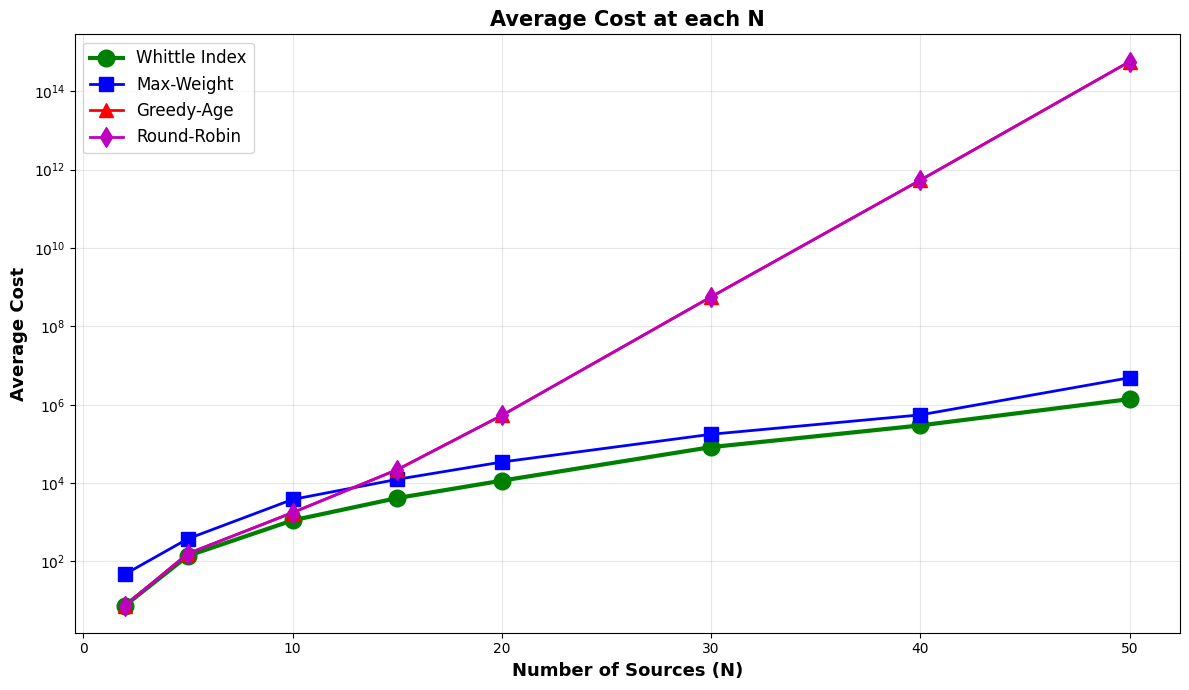

In [19]:
#def W(age, f): return age*f(age+1) - sum(f(j) for j in range(1, age+1))

# for the simulation, we assume that all sources are on reliable channel, 
# in the paper, we have Whittle index, weighted version, you can use all weight = 1 or weight = what the paper do
# and i also add greedy age (pick max age at each simulation), also round robin which is pick sources one by one
def sim(policy, funcs, weights, T=3000):
    N, ages, cost = len(funcs), [1]*len(funcs), 0
    for t in range(T):
        cost += sum(funcs[i](ages[i]) for i in range(N))
        if policy == 'W': sel = np.argmax([whittle_index_reliable(ages[i], funcs[i]) for i in range(N)])
        elif policy == 'MW': sel = np.argmax([weights[i]*ages[i]*(ages[i]+2) for i in range(N)])
        elif policy == 'GA': sel = np.argmax(ages)
        elif policy == 'RR': sel = t % N
        ages = [1 if i==sel else ages[i]+1 for i in range(N)]
    return cost/T

N_vals = [2, 5, 10, 15, 20, 30, 40, 50]
W_costs, MW_costs, GA_costs, RR_costs = [], [], [], []

weight_candidates = np.array([100, 1000, 15, 50])
weights = weight_candidates[np.arange(N) % 4]
# or we can just do weights = [1]*N
# it is quite obvious in this setting, round robin is bascially equivalent to greedy age since all sources increase age with the same speed
# unless they are different speed

for N in N_vals:
    # these functions are picked in the paper
    funcs = [lambda x, i=i: [x**3, 2**x, 15*x, x**2][i%4] for i in range(N)]
    W_costs.append(sim('W', funcs, None))
    MW_costs.append(sim('MW', funcs, weights))
    GA_costs.append(sim('GA', funcs, None))
    RR_costs.append(sim('RR', funcs, None))

plt.figure(figsize=(12,7))
plt.plot(N_vals, W_costs, 'go-', lw=3, ms=12, label='Whittle Index')
plt.plot(N_vals, MW_costs, 'bs-', lw=2, ms=10, label='Max-Weight')
plt.plot(N_vals, GA_costs, 'r^-', lw=2, ms=10, label='Greedy-Age')
plt.plot(N_vals, RR_costs, 'md-', lw=2, ms=10, label='Round-Robin')
plt.xlabel('Number of Sources (N)', fontsize=13, fontweight='bold')
plt.ylabel('Average Cost', fontsize=13, fontweight='bold')
plt.title('Average Cost at each N', fontsize=15, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()